In [1]:
!pip install diffusers accelerate transformers peft torchvision
!pip install pytorch-fid open-clip-torch matplotlib seaborn zipfile36

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Install required packages (if not already installed)
!pip install accelerate torch tqdm --quiet

import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import zipfile
from datetime import datetime
from collections import defaultdict

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from diffusers import (StableDiffusionImg2ImgPipeline,
                       UNet2DConditionModel,
                       AutoencoderKL)
from transformers import CLIPTokenizer, CLIPTextModel, CLIPFeatureExtractor
from diffusers import DDIMScheduler
import numpy as np
from peft import LoraConfig, get_peft_model, PeftModel
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
import json

# For metrics calculation
import open_clip
from pytorch_fid import fid_score
import torch.nn.functional as F

In [3]:
if os.path.exists('data1.zip'):
    print("Extracting data1.zip...")
    with zipfile.ZipFile('data1.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Extraction complete!")
else:
    print("data.zip not found. Please upload the file first.")

Extracting data1.zip...
Extraction complete!


In [4]:


print("Checking data1 structure...")
# if os.path.exists('data1'):
#     print("✓ data1 folder found")
#     if os.path.exists('data1/data'):  # CORRECTED: data1/data
#         print("✓ data1/data folder found")
tif_files = [f for f in os.listdir('data1') if f.endswith('.tif')]
# jpg_files = [f for f in os.listdir('data1') if f.endswith('.jpg')]
#         # print(f"✓ Found {len(tif_files)} .tif files")
#         print(f"✓ Found {len(jpg_files)} .jpg files")
#     else:
#         print("✗ data1/data folder not found")
# else:
#     print("✗ data1 folder not found")

# List first few files to verify
if os.path.exists('data1'):  # CORRECTED: data1/data
    print("\nFirst 5 files in data1:")
    files = os.listdir('data1')[:5]
    for f in files:
        print(f"  - {f}")

Checking data1 structure...

First 5 files in data1:
  - 20161008_153105_0e3a_16936-29815-16.tif
  - 20161008_153105_0e3a_16907-29805-16.tif
  - 20170326_153234_0e26_17057-29750-16.tif
  - 20170323_152750_0e20_17297-29802-16.tif
  - 20170322_153132_0e0f_17138-29800-16.tif


In [5]:
# Configuration
CONFIG = {
    'dataset_folder': 'data1',  # Main dataset folder
    'output_dir': 'stable_diffusion_output',
    'model_id': 'stabilityai/stable-diffusion-2-1',
    'num_epochs': 5,
    'batch_size': 1,
    'learning_rate': 1e-4,
    'image_size': 512,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']}")
print(f"Dataset folder: {CONFIG['dataset_folder']}")

######################################
# Part 1: Enhanced Dataset Class
######################################

class SatelliteDataset(Dataset):
    def __init__(self, folder, transform=None, use_tif=True):
        self.folder = folder
        # Use .tif files for better quality satellite images
        if use_tif:
            self.image_files = [os.path.join(folder, f) for f in os.listdir(folder)
                                if f.lower().endswith('.tif')]
        else:
            self.image_files = [os.path.join(folder, f) for f in os.listdir(folder)
                                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        print(f"Found {len(self.image_files)} images in {folder}")

        self.transform = transform if transform is not None else T.Compose([
            T.Resize((CONFIG['image_size'], CONFIG['image_size'])),
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

Using device: cuda
Dataset folder: data1


In [6]:
def fine_tune_model(dataset_folder="data1/data",
                    output_dir="fine_tuned_satellite_model",
                    num_epochs=5,
                    batch_size=1,
                    lr=1e-4):
    device = CONFIG['device']
    model_id = CONFIG['model_id'] # Use model_id from CONFIG

    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "metrics"), exist_ok=True)

    print("Loading base VAE and UNet...")
    vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
    unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")

    # Set up LoRA for parameter-efficient fine-tuning
    lora_config = LoraConfig(
        r=8,
        lora_alpha=32,
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
        lora_dropout=0.05,
    )
    unet = get_peft_model(unet, lora_config)
    unet.print_trainable_parameters()

    # Enable gradient checkpointing
    unet.enable_gradient_checkpointing()

    vae.to(device)
    unet.to(device)

    # Prepare the dataset
    transform = T.Compose([
        T.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3)
    ])
    dataset = SatelliteDataset(dataset_folder, transform=transform, use_tif=True)

    # Split dataset for training/validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    optimizer = torch.optim.AdamW(unet.parameters(), lr=lr)

    # FIXED: Use new GradScaler syntax
    if device == 'cuda':
        scaler = torch.amp.GradScaler('cuda')
    else:
        scaler = torch.amp.GradScaler('cpu')

    # Metrics tracking
    training_losses = []
    validation_losses = []

    print("Starting fine-tuning on satellite images...")
    for epoch in range(num_epochs):
        # Training
        unet.train()
        epoch_train_loss = 0.0
        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            batch = batch.to(device)
            optimizer.zero_grad()

            # FIXED: Use new autocast syntax
            if device == 'cuda':
                with torch.amp.autocast('cuda'):
                    latents = vae.encode(batch).latent_dist.sample() * 0.18215
                    timesteps = torch.randint(0, 1000, (batch.size(0),), device=device)
                    # FIXED: Correct the dummy text embedding size to 1024 for stable-diffusion-2-1
                    dummy_text_embeddings = torch.zeros((batch.size(0), 77, 1024), device=device)
                    noise_pred = unet(latents, timesteps, encoder_hidden_states=dummy_text_embeddings).sample
                    loss = torch.nn.functional.mse_loss(noise_pred, latents)
            else:
                latents = vae.encode(batch).latent_dist.sample() * 0.18215
                timesteps = torch.randint(0, 1000, (batch.size(0),), device=device)
                # FIXED: Correct the dummy text embedding size to 1024 for stable-diffusion-2-1
                dummy_text_embeddings = torch.zeros((batch.size(0), 77, 1024), device=device)
                noise_pred = unet(latents, timesteps, encoder_hidden_states=dummy_text_embeddings).sample
                loss = torch.nn.functional.mse_loss(noise_pred, latents)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_train_loss += loss.item()
            torch.cuda.empty_cache()

        # Validation
        unet.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                batch = batch.to(device)

                # FIXED: Use new autocast syntax
                if device == 'cuda':
                    with torch.amp.autocast('cuda'):
                        latents = vae.encode(batch).latent_dist.sample() * 0.18215
                        timesteps = torch.randint(0, 1000, (batch.size(0),), device=device)
                        # FIXED: Correct the dummy text embedding size to 1024 for stable-diffusion-2-1
                        dummy_text_embeddings = torch.zeros((batch.size(0), 77, 1024), device=device)
                        noise_pred = unet(latents, timesteps, encoder_hidden_states=dummy_text_embeddings).sample
                        loss = torch.nn.functional.mse_loss(noise_pred, latents)
                else:
                    latents = vae.encode(batch).latent_dist.sample() * 0.18215
                    timesteps = torch.randint(0, 1000, (batch.size(0),), device=device)
                    # FIXED: Correct the dummy text embedding size to 1024 for stable-diffusion-2-1
                    dummy_text_embeddings = torch.zeros((batch.size(0), 77, 1024), device=device)
                    noise_pred = unet(latents, timesteps, encoder_hidden_states=dummy_text_embeddings).sample
                    loss = torch.nn.functional.mse_loss(noise_pred, latents)

                epoch_val_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_dataloader)
        avg_val_loss = epoch_val_loss / len(val_dataloader)

        training_losses.append(avg_train_loss)
        validation_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss', color='blue')
    plt.plot(validation_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "metrics", "training_validation_loss.png"))
    plt.show()

    # Save fine-tuned model
    unet_save_dir = os.path.join(output_dir, "unet")
    vae_save_dir = os.path.join(output_dir, "vae")
    os.makedirs(unet_save_dir, exist_ok=True)
    os.makedirs(vae_save_dir, exist_ok=True)

    unet.save_pretrained(unet_save_dir)
    vae.save_pretrained(vae_save_dir)

    # Save metrics
    metrics = {
        'training_losses': training_losses,
        'validation_losses': validation_losses,
        'final_training_loss': training_losses[-1],
        'final_validation_loss': validation_losses[-1]
    }

    with open(os.path.join(output_dir, "metrics", "training_metrics.json"), 'w') as f:
        json.dump(metrics, f, indent=2)

    print("Fine-tuning completed and model saved at:", output_dir)
    return output_dir

In [7]:
import os
import torch
import random
from diffusers import StableDiffusionImg2ImgPipeline, DPMSolverMultistepScheduler
from transformers import CLIPImageProcessor, CLIPTokenizer, CLIPTextModel
from PIL import Image, ImageEnhance
from peft import PeftModel
from diffusers import UNet2DConditionModel, AutoencoderKL

# # Enhanced satellite prompts
# SATELLITE_PROMPTS = [
#     "Sentinel-2 B08 NIR image: plastic accumulation zones in the North Pacific Gyre at 32.1°N 145.7°W, low chlorophyll concentration, strong reflectance at 842 nanometers, water-leaving radiance > 5 W/m²/sr/μm, microplastic index over 0.6, no cloud contamination, minimal wave interference",

#     "Landsat-9 surface reflectance image of estuarine litter patch at 29.8°N 90.1°W, Mississippi Delta, plastic-dominated flotsam in turbid outflow, reflectance anomaly at 1650–1750 nm, suspended solids concentration 80 mg/L, anthropogenic signature confirmed via spectral unmixing",

#     "Sentinel-3 OLCI image: South China Sea at 12.6°N 110.2°E, foam-plastic mixture observed on coastal shelf edge, visible and NIR bands showing high scattering, sunglint conditions moderate, plastic polymer absorption bands near 1215 and 1735 nm detected with 80% confidence",

#     "Multispectral satellite image (WorldView-3): urban river segment in Jakarta at 6.2°S 106.8°E, accumulated macroplastic raft near bridge structure, multispectral plastic index exceeding 0.7, solar zenith angle 47°, shadow correction applied, high-resolution panchromatic band confirms debris geometry",

#     "MODIS-Aqua 250m resolution: equatorial upwelling zone at 0.8°N 134.9°W, dispersed synthetic particles with specular reflection hotspots, red-edge reflectance peak at 710 nm, normalized difference plastic index (NDPI) > 0.5, concurrent SST anomaly of +1.2°C, cloud mask applied"
# ,
#         "Sentinel-2 B11 SWIR image: clear ocean surface at 23.6°S 46.5°W with plastic debris field , 0.5 kilometer dispersion index, buoyant fraction greater than 80%, spectral signature at 1215 nanometers, sunglint, NIR to SWIR ratio greater than 1.7, atmospheric correction 6S, no ships or cloud cover",
#     "Plastic debris field floating on clear ocean surface viewed from satellite perspective, South Atlantic waters, scattered white and colored fragments across blue expanse, 500-meter dispersal pattern, bright sunglint reflections"
# ,
#     "Landsat-8 mixed litter in river plume outflow at 8.4°S 13.2°E, turbidity 15 NTU , colored dissolved organic matter absorption 0.2 per meter, diagnostic spectral features: polyethylene at 1660 nanometers, polyvinyl chloride at 1735 nanometers"

# ]
SATELLITE_PROMPTS =
 ["Realistic Sentinel-2 satellite image showing river plume discharging plastic waste into ocean, 10m resolution with visible debris lines following currents, natural color rendering"
,"High-detail Copernicus satellite view of a realistic accumulation of mixed marine debris in the Pacific Ocean, 20 meter spatial resolution, no cloud contamination, minimal wave interference"
,"Realistic Landsat-8 of mixed marine plastics in river plume outflow 5 meter spatial resolution, bright sunlight reflections, no ships or cloud cover "
,"Satellite view of ocean plastic pollution near coastlines, visible microplastics and trash patches, remote sensing of marine pollution"
,"Satellite view of ocean plastic pollution streaks of macroplastics and trash patches, 30meter spatial resolution remote sensing of marine pollution"
,"Realistic satellite view of ocean plastic pollution, near coastline, 10meter spatial resolution, sunglint"]


class SatelliteImageGenerator:
    def __init__(self, fine_tuned_model_dir):
        device = CONFIG['device']
        unet_path = os.path.join(fine_tuned_model_dir, "unet")
        vae_path = os.path.join(fine_tuned_model_dir, "vae")

        print("Loading model... (This will only happen once)")
        # Load the base UNet from the same model_id used for fine-tuning
        base_unet = UNet2DConditionModel.from_pretrained(CONFIG['model_id'], subfolder="unet")
        unet = PeftModel.from_pretrained(base_unet, unet_path)
        vae = AutoencoderKL.from_pretrained(vae_path)

        # FIXED: Load CLIPTextModel and CLIPTokenizer from stable-diffusion-2-1-base
        tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-2-1-base", subfolder="tokenizer")
        text_encoder = CLIPTextModel.from_pretrained("stabilityai/stable-diffusion-2-1-base", subfolder="text_encoder")

        scheduler = DPMSolverMultistepScheduler.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="scheduler")
        feature_extractor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

        self.pipe = StableDiffusionImg2ImgPipeline(
            unet=unet,
            vae=vae,
            tokenizer=tokenizer,
            text_encoder=text_encoder,
            scheduler=scheduler,
            feature_extractor=feature_extractor,
            safety_checker=None,
            requires_safety_checker=False
        ).to(device)

    def generate_image(self, input_image_path, prompt=None, target_width=1024, target_height=1024,
                       strength=0.7, guidance_scale=7.5, num_inference_steps=30, seed=None):
        device = CONFIG['device']

        init_image = Image.open(input_image_path).convert("RGB")
        init_image = init_image.resize((512, 512))

        enhancer = ImageEnhance.Brightness(init_image)
        init_image = enhancer.enhance(random.uniform(0.8, 1.2))
        init_image = init_image.rotate(random.choice([0, 90, 180, 270]))

        if prompt is None:
            prompt = random.choice(SATELLITE_PROMPTS)

        generator = torch.manual_seed(seed) if seed else None
        result = self.pipe(
            prompt=prompt,
            image=init_image,
            strength=random.uniform(0.4, 0.6),
            guidance_scale=random.uniform(6.5, 8.5),
            height=target_height,
            width=target_width,
            num_inference_steps=num_inference_steps,
            generator=generator
        )

        return result.images[0]

    def generate_batch_images(self, input_image_path, batch_size, output_dir):
        """Generate a specific batch size of images"""
        os.makedirs(output_dir, exist_ok=True)

        print(f"Generating {batch_size} images in {output_dir}...")

        for i in tqdm(range(batch_size), desc=f"Generating batch of {batch_size}"):
            generated_image = self.generate_image(
                input_image_path=input_image_path,
                prompt=random.choice(SATELLITE_PROMPTS),
                strength=random.uniform(0.6, 0.9),
                guidance_scale=random.uniform(6.5, 8.5),
                num_inference_steps=random.randint(40, 60),
                seed=random.randint(0, 10000)
            )

            output_path = os.path.join(output_dir, f"generated_image_{i+1:04d}.png")
            generated_image.save(output_path)

        print(f"Generated {batch_size} images in {output_dir}")

In [8]:
class MetricsCalculator:
    def __init__(self):
        self.device = CONFIG['device']
        # Load CLIP model for CLIP score calculation
        self.clip_model, _, self.clip_preprocess = open_clip.create_model_and_transforms(
            'ViT-B-32', pretrained='openai'
        )
        self.clip_model.to(self.device)

    def calculate_clip_score(self, generated_images, prompts):

        """Calculate CLIP score between generated images and prompts"""
        scores = []

        for img, prompt in zip(generated_images, prompts):

            # Preprocess image
            img_tensor = self.clip_preprocess(img).unsqueeze(0).to(self.device)

            # Encode image and text
            with torch.no_grad():
                image_features = self.clip_model.encode_image(img_tensor)
                text_features = self.clip_model.encode_text(
                    open_clip.tokenize([prompt]).to(self.device)
                )

                # Normalize features
                image_features = F.normalize(image_features, dim=-1)
                text_features = F.normalize(text_features, dim=-1)

                # Calculate cosine similarity
                score = (image_features * text_features).sum(dim=-1).item()
                scores.append(score)

        return np.mean(scores), scores

    def calculate_fid_score(self, real_images_dir, generated_images_dir):
        """Calculate FID score between real and generated images"""
        try:
            fid_value = fid_score.calculate_fid_given_paths(
                [real_images_dir, generated_images_dir],
                batch_size=50,
                device=self.device
            )
            return fid_value
        except Exception as e:
            print(f"Error calculating FID: {e}")
            return None

def create_metrics_visualizations(metrics_data, output_dir):
    """Create visualization plots for all metrics"""
    os.makedirs(output_dir, exist_ok=True)

    # CLIP Score visualization
    if 'clip_scores' in metrics_data:
        plt.figure(figsize=(10, 6))
        plt.plot(metrics_data['clip_scores'])
        plt.xlabel('Image Index')
        plt.ylabel('CLIP Score')
        plt.title('CLIP Scores for Generated Images')
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, 'clip_scores.png'))
        plt.show()

    # FID Score comparison
    if 'fid_scores' in metrics_data:
        plt.figure(figsize=(10, 6))
        batch_sizes = list(metrics_data['fid_scores'].keys())
        fid_values = list(metrics_data['fid_scores'].values())
        plt.bar(batch_sizes, fid_values)
        plt.xlabel('Batch Size')
        plt.ylabel('FID Score')
        plt.title('FID Scores for Different Batch Sizes')
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, 'fid_scores.png'))
        plt.show()

In [9]:
from huggingface_hub import login
login()

In [10]:
import os

input_image_path = 'Input_image_satellite.png' # Replace with your desired path

if os.path.exists(input_image_path):
    print(f"The file '{input_image_path}' exists.")
else:
    print(f"The file '{input_image_path}' does not exist.")

The file 'Input_image_satellite.png' exists.


=== Step 1: Fine-tuning Stable Diffusion ===
Loading base VAE and UNet...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

trainable params: 1,659,904 || all params: 867,570,628 || trainable%: 0.1913
Found 200 images in data1
Starting fine-tuning on satellite images...


Training Epoch 1/5:   0%|          | 0/160 [00:00<?, ?it/s]

Validation Epoch 1/5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 - Training Loss: 1.7358, Validation Loss: 0.4062


Training Epoch 2/5:   0%|          | 0/160 [00:00<?, ?it/s]

Validation Epoch 2/5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 - Training Loss: 0.3042, Validation Loss: 0.2318


Training Epoch 3/5:   0%|          | 0/160 [00:00<?, ?it/s]

Validation Epoch 3/5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 - Training Loss: 0.2112, Validation Loss: 0.1718


Training Epoch 4/5:   0%|          | 0/160 [00:00<?, ?it/s]

Validation Epoch 4/5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 - Training Loss: 0.1466, Validation Loss: 0.1235


Training Epoch 5/5:   0%|          | 0/160 [00:00<?, ?it/s]

Validation Epoch 5/5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 - Training Loss: 0.1133, Validation Loss: 0.1029


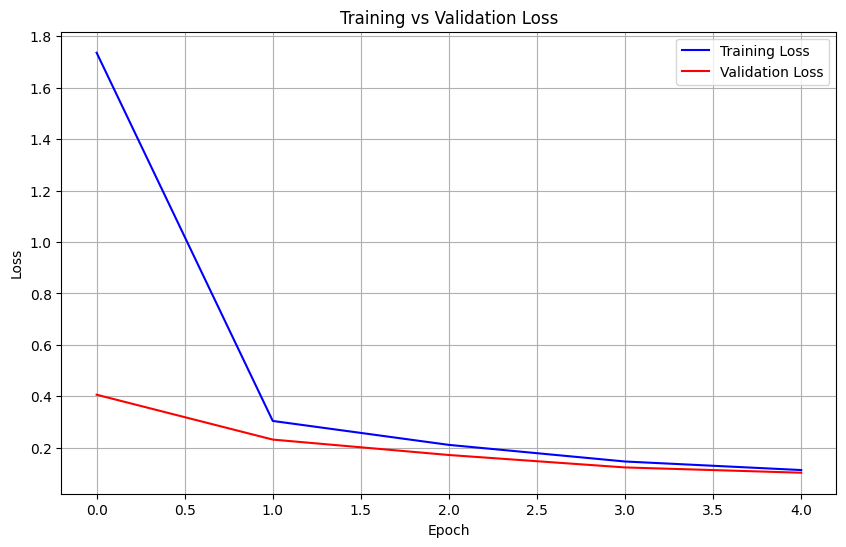

Fine-tuning completed and model saved at: fine_tuned_satellite_model
=== Step 2: Initializing Image Generator ===
Loading model... (This will only happen once)


tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

=== Step 3: Generating Image Batches ===
Found 200 images in data1
Using first image from dataset as input: data1/20161008_153105_0e3a_16936-29815-16.tif
Generating 10 images in stable_diffusion_output/batch_10...


Generating batch of 10:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Generated 10 images in stable_diffusion_output/batch_10
=== Step 4: Calculating Diversity Metrics ===


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Error calculating FID: calculate_fid_given_paths() missing 1 required positional argument: 'dims'
=== Step 5: Creating Visualizations ===


TypeError: float() argument must be a string or a real number, not 'dict'

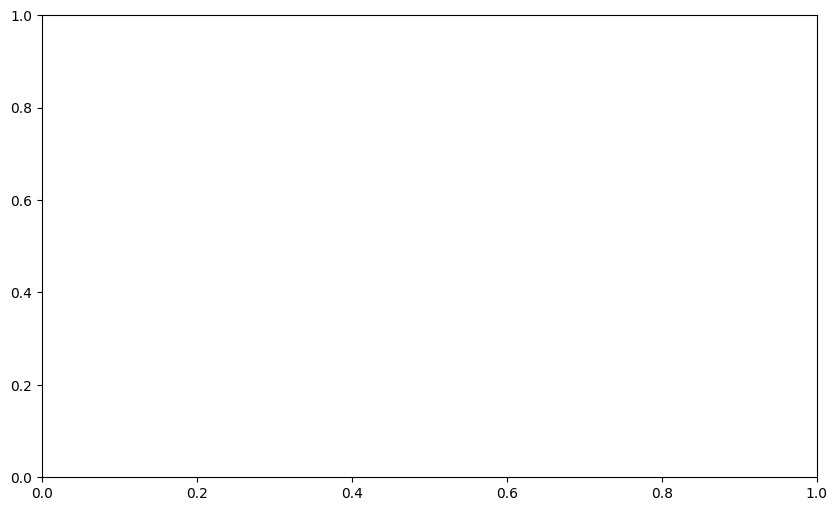

In [11]:
# # Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe = pipe.to("cuda")

# prompt = "a photo of an astronaut riding a horse on mars"
# neg_prompt = "((white astronaut suit)), (((distorted limbs))), (((bad proportions))), ((extra limbs))"

# images = pipe(prompt, negative_prompt=neg_prompt).images[0]


def run_stable_diffusion_pipeline(input_image_path=None):
    """Complete pipeline"""

    # Step 1: Fine-tune the model
    print("=== Step 1: Fine-tuning Stable Diffusion ===")
    fine_tuned_dir = fine_tune_model(
        dataset_folder=CONFIG['dataset_folder'],
        num_epochs=CONFIG['num_epochs']
    )

    # Step 2: Initialize generator
    print("=== Step 2: Initializing Image Generator ===")
    generator = SatelliteImageGenerator(fine_tuned_dir)

    # Step 3: Generate batches
    print("=== Step 3: Generating Image Batches ===")
    batch_sizes = [10]

    # Use first image as input for generation if no specific path is provided
    if input_image_path is None:
        dataset = SatelliteDataset(CONFIG['dataset_folder'], use_tif=True)
        if dataset.image_files:
            input_image_path = dataset.image_files[0]
            print(f"Using first image from dataset as input: {input_image_path}")
        else:
            raise ValueError(f"No image files found in the dataset folder: {CONFIG['dataset_folder']}")
    else:
        if not os.path.exists(input_image_path):
            raise FileNotFoundError(f"Input image not found at: {input_image_path}")
        print(f"Using specified input image: {input_image_path}")


    for batch_size in batch_sizes:
        output_dir = os.path.join(CONFIG['output_dir'], f"batch_{batch_size}")
        generator.generate_batch_images(input_image_path, batch_size, output_dir)

    # Step 4: Calculate metrics
    print("=== Step 4: Calculating Diversity Metrics ===")
    metrics_calc = MetricsCalculator()
    metrics_data = {
        'clip_scores': {},
        'fid_scores': {}
    }

    # Calculate FID scores for each batch
    for batch_size in batch_sizes:
        generated_dir = os.path.join(CONFIG['output_dir'], f"batch_{batch_size}")
        fid_score = metrics_calc.calculate_fid_score(CONFIG['dataset_folder'], generated_dir)
        if fid_score:
            metrics_data['fid_scores'][batch_size] = fid_score

    # Calculate CLIP scores for a sample of generated images
    sample_size = 200
    for batch_size in batch_sizes:
        generated_dir = os.path.join(CONFIG['output_dir'], f"batch_{batch_size}")
        generated_files = [f for f in os.listdir(generated_dir) if f.endswith('.png')][:sample_size]

        generated_images = []
        prompts = []

        for file in generated_files:
            img_path = os.path.join(generated_dir, file)
            img = Image.open(img_path)
            generated_images.append(img)
            prompts.append(random.choice(SATELLITE_PROMPTS))

        clip_score, clip_scores = metrics_calc.calculate_clip_score(generated_images, prompts)

        metrics_data['clip_scores'][batch_size] = {
            'mean': clip_score,
            'individual': clip_scores
        }

    # Step 5: Create visualizations
    print("=== Step 5: Creating Visualizations ===")
    create_metrics_visualizations(metrics_data, os.path.join(CONFIG['output_dir'], 'metrics'))

    # Step 6: Save final metrics
    with open(os.path.join(CONFIG['output_dir'], 'metrics', 'final_metrics.json'), 'w') as f:
        json.dump(metrics_data, f, indent=2)

    # Step 7: Create zip files
    print("=== Step 6: Creating Output Zip Files ===")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    for batch_size in batch_sizes:
        batch_dir = os.path.join(CONFIG['output_dir'], f"batch_{batch_size}")
        zip_path = os.path.join(CONFIG['output_dir'], f"stable_diffusion_batch_{batch_size}_{timestamp}.zip")

        with zipfile.ZipFile(zip_path, 'w') as zipf:
            for root, dirs, files in os.walk(batch_dir):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, batch_dir)
                    zipf.write(file_path, arcname)


    print(f"Output directory: {CONFIG['output_dir']}")
    print("Generated:")
    for batch_size in batch_sizes:
        print(f"  - {batch_size} images in batch_{batch_size}/")
        print(f"  - Zip file: stable_diffusion_batch_{batch_size}_{timestamp}.zip")
    print("  - Metrics and visualizations in metrics/")

# Run the complete pipeline
if __name__ == "__main__":
    run_stable_diffusion_pipeline()

In [ ]:
# Display sample generated images
import matplotlib.pyplot as plt
import os

def display_sample_images(batch_size=50, num_samples=5):
    image_dir = os.path.join(CONFIG['output_dir'], f"batch_{batch_size}")

    if not os.path.exists(image_dir):
        print(f"Directory {image_dir} not found. Run the pipeline first.")
        return

    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')][:num_samples]

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)
        try:
            img = plt.imread(image_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Generated {i+1}")
            axes[i].axis('off')
        except Exception as e:
            print(f"Error displaying image {image_file}: {e}")
            axes[i].set_title(f"Error loading {image_file}")

    plt.tight_layout()
    plt.show()

# Display sample images from batch 200
display_sample_images(batch_size=50, num_samples=5)